# RMs for RL

$$
\newcommand{\tuple}[1]{\left\langle #1 \right\rangle}
\newcommand{\StateSpace}[0]{\mathcal{S}}
\newcommand{\ActionSpace}[0]{\mathcal{A}}
\newcommand{\SAS}[0]{\StateSpace\times\ActionSpace\times\StateSpace}
\newcommand{\ContextSpace}[0]{\mathcal{C}}
\newcommand{\MDPFunc}[0]{\mathcal{M}}
\newcommand{\CMDP}[0]{\tuple{\ContextSpace, \StateSpace, \ActionSpace, \MDPFunc}}
\newcommand{\MDPInContext}[1]{\tuple{\StateSpace, \ActionSpace, p^{#1}, r^{#1}, \gamma}}
\newcommand{\propsym}[0]{\mathcal{P}}
\newcommand{\RM}[0]{\tuple{\propsym, U, \delta_u, \delta_r}}
\newcommand{\RMsym}[0]{\mathcal{R}}
\newcommand{\MDPRM}[0]{\tuple{\StateSpace , \ActionSpace, p,\gamma,\propsym, L, U, \delta_u, \delta_r}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
$$

## Problem Formulation

Let $X = \CMDP$ be a CMDP and let $\Psi$ be the distribution over $\ContextSpace$. Let $f$ be a parameterized function, called the _adaptation function_, that takes trajectories and outputs adapted parameters. Denote by $\tau_c^{1:K}$ a collection of $K$ trajectories collected within context $c\in\ContextSpace$. We would like to find meta parameters $\theta^*$ such that sampling few trajectories from parameterized policy $\pi_\theta $ and adapting $\theta$ to $\phi = f_\theta(\tau_c^{1:K})$ maximizes $\pi_\phi$'s return over $c\sim\Psi$. More formally, we would like to find:
\begin{equation}
    \theta^*\in\argmax{\theta}\mathbb{E}_{c\sim\Psi}\left[J_c(\pi_\phi)\middle|\phi = f_\theta(\tau_c^{1:K}), \tau_c^{1:K}\sim\pi_\theta\right]
\end{equation}
with the smallest $K$ possible. We measure performance using the "time to threshold" metric, that measures the number of samples/trajectories collected in order to achieve some threshold accumulated rewards.

## Method
![GNN RM usage](images/GNN_RM_usage.png)

## Imports and notebook utils

In [1]:
%load_ext tensorboard
%load_ext autoreload
%autoreload 2

from pathlib import Path

from rmrl.reward_machines.rm_env import RMEnvWrapper
from rmrl.envs.multitask_env import MultiTaskWrapper
from rmrl.envs.mujoco.half_cheetah import velocity_env
from rmrl.envs.mujoco.reward_machines.half_cheetah import VelocityRM
from rmrl.reward_machines.potential_functions import ValueIteration
from rmrl.nn.models import RMFeatureExtractorSB

from stable_baselines3 import DDPG

MODELS_DIR = Path('./models')
LOGS_DIR = Path('./logs')
TB_DIR = LOGS_DIR / 'tensorboard'


RS_GAMMA = 0.9
MAX_ITERS = 1000

/usr/local/Caskroom/miniconda/base/envs/rmrl/lib/python3.9/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, '__version__') or LooseVersion(tensorboard.__version__) < LooseVersion('1.15'):


In [2]:
def get_ddpg_trained_model(name, policy, env, timesteps):
    model = DDPG(policy=policy,
                 env=env,
                 verbose=1,
                 tensorboard_log=TB_DIR / name)
    # load model if exists
    try:
        print('loading pre-trained model')
        return model.load(MODELS_DIR / name, model.env)
    except FileNotFoundError:
        print('pre-trained model not found. training model')
        train_model(model, timesteps)
        model.save(MODELS_DIR / name)
        return model

def train_model(model, timesteps):
    try:
        iter(timesteps)
    except TypeError:
        timesteps = [timesteps]

    for i, ts in enumerate(timesteps, 1):
        print(f'run number {i}. {ts} timesteps')
        model.learn(total_timesteps=ts,
                    tb_log_name=f'run{i}',  # number the run logs
                    reset_num_timesteps=False)  # continue the same curve

def animate_env(model, num_iters=MAX_ITERS):
    env = model.env
    try:
        obs = env.reset()
        for i in range(num_iters):
            action, _state = model.predict(obs, deterministic=True)
            obs, reward, done, info = env.step(action)
            env.render()
            if done:
                obs = env.reset()
    except KeyboardInterrupt:
        print('Early stop by user')
    finally:
        env.close()

## Original cheetah env (move forward)

In [3]:
model_fw = get_ddpg_trained_model('ddpg_cheetah_fw',
                                  'MlpPolicy',
                                  'HalfCheetah-v4',
                                  timesteps=[1e4] * 4)  # 4 rounds of 10,000

Using cpu device
Creating environment from the given name 'HalfCheetah-v4'
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
loading pre-trained model


/usr/local/Caskroom/miniconda/base/envs/rmrl/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
/usr/local/Caskroom/miniconda/base/envs/rmrl/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:73: UserWarning: WARN: Agent's maximum action space value is infinity. This is probably too high
  logger.warn(
/usr/local/Caskroom/miniconda/base/envs/rmrl/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


In [4]:
%tensorboard --logdir ./logs/tensorboard/ddpg_cheetah_fw

In [5]:
animate_env(model_fw)

SystemExit: 0

/usr/local/Caskroom/miniconda/base/envs/rmrl/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3406: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Fixed velocity (5.0) cheetah env

In [7]:
fixed_vel_env = velocity_env(initial_goal_vel=5.0, change_task_on_reset=False)
fixed_vel_env.reset()
print(f'goal velocity is: {fixed_vel_env.task}')
print('goal changes on reset' if fixed_vel_env.change_task_on_reset else 'fixed goal')

goal velocity is: 5.0
fixed goal


/usr/local/Caskroom/miniconda/base/envs/rmrl/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
/usr/local/Caskroom/miniconda/base/envs/rmrl/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:73: UserWarning: WARN: Agent's maximum action space value is infinity. This is probably too high
  logger.warn(
/usr/local/Caskroom/miniconda/base/envs/rmrl/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


In [8]:
model_vel5 = get_ddpg_trained_model('ddpg_cheetah_vel5',
                                    'MlpPolicy',
                                    fixed_vel_env,
                                    timesteps=[1e4] * 4)  # 4 rounds of 10,000

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
loading pre-trained model
pre-trained model not found. training model
run number 1. 10000.0 timesteps
Logging to logs/tensorboard/ddpg_cheetah_vel5/run1_0
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1e+03     |
|    ep_rew_mean     | -5.31e+03 |
| time/              |           |
|    episodes        | 4         |
|    fps             | 121       |
|    time_elapsed    | 33        |
|    total timesteps | 4000      |
| train/             |           |
|    actor_loss      | 32.2      |
|    critic_loss     | 1.19      |
|    learning_rate   | 0.001     |
|    n_updates       | 3000      |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1e+03     |
|    ep_rew_mean     | -5.37e+03 |
| time/              |           |
|    episodes        | 8         |
|    fps        

In [9]:
%tensorboard --logdir ./logs/tensorboard/ddpg_cheetah_vel5

In [10]:
animate_env(model_vel5)

SystemExit: 0

/usr/local/Caskroom/miniconda/base/envs/rmrl/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3406: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## RM cheetah env

In [11]:
# function to create RMs in env wrapper
potential_fn = ValueIteration()
def rm_fn(task_env: MultiTaskWrapper):
    rm = VelocityRM(task_env.task)
    rm.reshape_rewards(potential_fn(rm, RS_GAMMA), gamma=RS_GAMMA)
    return [rm]

In [12]:
fixed_vel_env_rs = RMEnvWrapper(fixed_vel_env, rm_fn,
                                rm_observations=False,
                                change_rms_on_reset=False)  # fixed task. no need to reset RM

/Users/guyazran/Desktop/School/Master/Thesis/Sarah Keren/Research/code/RM-RL/rmrl/reward_machines/reward_machine.py:77: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.isin(self.P, props).astype(np.float).tolist()


A quick demo of the internal env reward machine and reward shaping

In [13]:
import numpy as np
fixed_vel_env_rs.reset()
fixed_vel_env_rs.step(np.array([0, 0, 0, 0, 0, 0]))

(array([-0.02463765,  0.01681699,  0.08506296, -0.00620499, -0.00800047,
         0.00900121,  0.00466257, -0.02324699,  0.00654387,  0.00670829,
        -0.43874071, -0.11814249,  0.20740644,  0.78727513, -0.55488654,
        -0.73871479,  1.64448715, -0.41886361]),
 -0.590489910185501,
 False,
 {'x_position': -0.024637652801506586,
  'x_velocity': 0.0027808132081523496,
  'reward_run': 0.0027808132081523496,
  'reward_ctrl': -0.0,
  'reward_vel': -4.997219186791848,
  'no-rm_reward': -4.997219186791848,
  'rm0_reward': -0.590489910185501,
  'rm0_propositions': ['0']})

goal velocity: 5.0


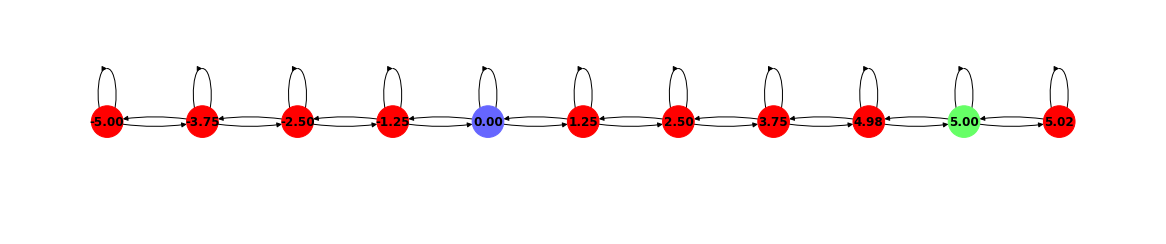

(7, -1.709999910185501)

In [14]:
print(f'goal velocity: {fixed_vel_env_rs.task}')
fixed_vel_env_rs.rms[0].draw()
fixed_vel_env_rs.rms[0].delta(8, ['75%'])

In [15]:
rm = fixed_vel_env_rs.rms[0]
rm.reset_rewards()

In [16]:
print(0, rm.G[0])
print()
print(1, rm.G[1])
print()
print(7, rm.G[7])
print()
print(8, rm.G[8])
print()
print(9, rm.G[9])
print()
print(10, rm.G[10])

0 {1: {'r': 0}, 0: {'r': 0}}

1 {2: {'r': 0}, 0: {'r': 0}, 1: {'r': 0}}

7 {8: {'r': 0}, 6: {'r': 0}, 7: {'r': 0}}

8 {9: {'r': 0}, 7: {'r': 0}, 8: {'r': 0}}

9 {10: {'r': 0}, 8: {'r': 0}, 9: {'r': 1}}

10 {9: {'r': 0}, 10: {'r': 0}}


In [17]:
pots = potential_fn(rm, RS_GAMMA)
pots

{0: 3.8742039918550075,
 1: 4.304671201855009,
 2: 4.782968101855007,
 3: 5.3144091018550075,
 4: 5.904899101855009,
 5: 6.560999101855009,
 6: 7.28999910185501,
 7: 8.09999910185501,
 8: 8.99999910185501,
 9: 9.99999910185501,
 10: 8.99999910185501}

In [18]:
rm.reshape_rewards(pots, RS_GAMMA)

In [19]:
print(0, rm.G[0])
print()
print(1, rm.G[1])
print()
print(7, rm.G[7])
print()
print(8, rm.G[8])
print()
print(9, rm.G[9])
print()
print(10, rm.G[10])

0 {1: {'r': 8.981450072553798e-08}, 0: {'r': -0.38742039918550075}}

1 {2: {'r': 8.981449806100272e-08}, 0: {'r': -0.8178876091855023}, 1: {'r': -0.4304671201855008}}

7 {8: {'r': 8.981449894918114e-08}, 6: {'r': -1.5389999101855016}, 7: {'r': -0.8099999101855007}}

8 {9: {'r': 8.981449894918114e-08}, 7: {'r': -1.709999910185501}, 8: {'r': -0.8999999101855014}}

9 {10: {'r': -1.8999999101855014}, 8: {'r': -1.8999999101855014}, 9: {'r': 8.981449894918114e-08}}

10 {9: {'r': 8.981449894918114e-08}, 10: {'r': -0.8999999101855014}}


Back to training models

In [20]:
model_vel5_rs = get_ddpg_trained_model('ddpg_cheetah_vel5_rs',
                                       'MlpPolicy',
                                       fixed_vel_env_rs,
                                       timesteps=[1e4] * 4)  # 4 rounds of 10,000

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
loading pre-trained model
pre-trained model not found. training model
run number 1. 10000.0 timesteps
Logging to logs/tensorboard/ddpg_cheetah_vel5_rs/run1_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -590     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 120      |
|    time_elapsed    | 33       |
|    total timesteps | 4000     |
| train/             |          |
|    actor_loss      | 3.91     |
|    critic_loss     | 0.0207   |
|    learning_rate   | 0.001    |
|    n_updates       | 3000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -590     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 103      |


In [21]:
%tensorboard --logdir ./logs/tensorboard/ddpg_cheetah_vel5_rs

In [25]:
animate_env(fixed_vel_env_rs)

## With RM as graph input

In [26]:
fixed_vel_env_rs_graph_input = RMEnvWrapper(fixed_vel_env, rm_fn,
                                            rm_observations=True,
                                            change_rms_on_reset=False)

In [27]:
## TODO support policy_kwargs in "get_ddpg_trained_model" function
policy_kwargs = dict(
    features_extractor_class=RMFeatureExtractorSB
)

model_vel_rs_gnn = DDPG('MultiInputPolicy',
                        fixed_vel_env_rs_graph_input,
                        verbose=1,
                        tensorboard_log="./ddpg_cheetah_vel5.0_rs_gnn_tensorboard/",
                        policy_kwargs=policy_kwargs,
                        batch_size=1)
model_vel_rs_gnn.learn(total_timesteps=10_000, tb_log_name="run_1", reset_num_timesteps=False)
model_vel_rs_gnn.learn(total_timesteps=10_000, tb_log_name="run_2", reset_num_timesteps=False)
model_vel_rs_gnn.learn(total_timesteps=10_000, tb_log_name="run_3", reset_num_timesteps=False)
model_vel_rs_gnn.learn(total_timesteps=10_000, tb_log_name="run_4", reset_num_timesteps=False)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./ddpg_cheetah_vel5.0_rs_gnn_tensorboard/run_1_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -590     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 95       |
|    time_elapsed    | 42       |
|    total timesteps | 4000     |
| train/             |          |
|    actor_loss      | 5.09     |
|    critic_loss     | 0.131    |
|    learning_rate   | 0.001    |
|    n_updates       | 3000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -590     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 83       |
|    time_elapsed    | 95       |
|    total timesteps | 8000     |
| train/             |        

In [28]:
%tensorboard --logdir ./ddpg_cheetah_vel5.0_rs_gnn_tensorboard/

In [30]:
animate_env(fixed_vel_env_rs_graph_input)